# Learning to pivot

Main paper: https://arxiv.org/abs/1611.01046

In the notebook, we are going to make classifier's predictions independent from a *nuisance* parameters.
While nuisance parameters themselves can be not explicitely present in the dataset, they can be partially inffered from the rest of the features.

In [1]:
try:
    import mlhep2019
except ModuleNotFoundError:
    import subprocess as sp
    result = sp.run(
        ['pip', 'install', 'git+https://github.com/yandexdataschool/mlhep2019.git'],
        stdout=sp.PIPE, stderr=sp.PIPE
    )
    
    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))
    
    import mlhep2019

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import numpy as np
import torch
import torch.utils.data

from mlhep2019.pivot import get_susy, split
from mlhep2019.pivot import nuisance_metric_plot, nuisance_prediction_hist

In [3]:
for i in range(torch.cuda.device_count()):
  print(torch.cuda.get_device_name(i))

GeForce GTX 1080 Ti


In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = "cpu"
  print('Using CPU')

## Downloading SUSY dataset

The dataset can be found at https://archive.ics.uci.edu/ml/datasets/SUSY

The original paper is:
Baldi, P., P. Sadowski, and D. Whiteson. “Searching for Exotic Particles in High-energy Physics with Deep Learning.” Nature Communications 5 (July 2, 2014)

### Data Set Information:

Provide all relevant informatioThe data has been produced using Monte Carlo simulations. The first 8 features are kinematic properties measured by the particle detectors in the accelerator. The last ten features are functions of the first 8 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks and the dropout algorithm are presented in the original paper. The last 500,000 examples are used as a test set.n about your data set.

### Attribute Information:

The first column is the class label (1 for signal, 0 for background), followed by the 18 features (8 low-level features then 10 high-level features):: lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1). For detailed information about each feature see the original paper.

In [5]:
data, labels = get_susy('SUSY/')

In [6]:
data_train, labels_train, data_test, labels_test = split(data, labels, split_ratios=(10, 1))

In [7]:
data_mean, data_std = np.mean(data_train, axis=0), np.std(data_train, axis=0)

In [8]:
data_train -= data_mean[None, :]
data_train /= data_std[None, :]

### never use test statistics to transform the test dataset!
data_test -= data_mean[None, :]
data_test /= data_std[None, :]

Here we select the first feature 'lepton 1 pT' as nuisance parameter. Feel free to try a different nusiance parameter, or, perhaps, several nuisance parameters at once.

In [9]:
data_train, nuisance_train = data_train[:, 1:], data_train[:, 0]
data_test, nuisance_test = data_test[:, 1:], data_test[:, 0]

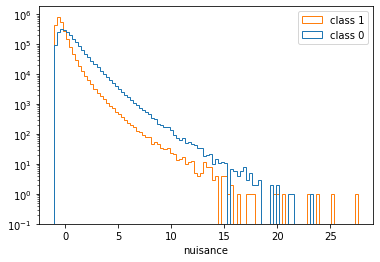

In [10]:
plt.hist(
    [nuisance_train[labels_train > 0.5], nuisance_train[labels_train < 0.5]],
    bins=100, histtype='step', label=['class 0', 'class 1'], log=True
)
plt.xlabel('nuisance')
plt.legend()
plt.show()

In [11]:
X_train, X_test, y_train, y_test, z_train, z_test = [
    torch.tensor(x).to(device)
    for x in [data_train, data_test, labels_train, labels_test, nuisance_train, nuisance_test]
]

In [12]:
dataset_test = torch.utils.data.TensorDataset(X_test, y_test, z_test)
loader_test =  torch.utils.data.DataLoader(dataset_test, batch_size=1024, shuffle=False)

def test_predictions(model):
    with torch.no_grad():
        return np.concatenate([
            torch.sigmoid(model(X_batch)).to('cpu').detach().numpy()
            for X_batch, _, _ in loader_test
        ], axis=0)

## Task

- choose between conditional and unconditional pivoting (or both);
- implement and train ordinary classifier;
- implement and train pivoted classifier;
- compare ROC AUC score depending on nuisance parameter;
- make sure, that the Mutual Information (MI) for pivoted classifier is lower than MI for ordinary classifier.

### Classifier

SUSY and HIGGS datasets are quite difficult classification problems.
It is recommended to use networks with 3-5 dense layers, 100+ units each.

### Adversary

- The nuisance parameter is continuous, therefore, a regression loss should be used (e.g. MSE, MAE).
- Adversary should be a small network, 1 hidden layer with ~64 units is fine.
- Try to find a good coefficient $\lambda$ in $\mathcal{L}_\mathrm{clf} - \lambda \mathcal{L}_\mathrm{adv}$.


### Extra tasks
(can be implemented out of order)

- try to make adversary loss extremely high (more than $10$ times higher than the loss of the optimal constant), but:
    - use 16 steps of the adversary training per one step of the classifier training;
    - adversary must converge on its own with fixed classifier;
- implement both types of pivoting;
- include nuisance parameter in the feature set (keeping it as nuisance parameter), and train pivoted classifier;
- try several nuisance parameters at once;
- compare different regression losses for the adversary (e.g. MSE vs MAE).

In [19]:
class Classifier(torch.nn.Module):
    ### define classifier here
    ### don't forget about torch.squeeze
    def __init__(self, activation = torch.nn.LeakyReLU()):
        super(Classifier, self).__init__()
        
        self.Layer1 = torch.nn.Linear(17,128)
        self.Layer2 = torch.nn.Linear(128,1024)
        self.Layer3 = torch.nn.Linear(1024,256)
        self.Layer4 = torch.nn.Linear(256,1)
        
        self.activation = activation
        
    def forward(self, X):
        
        result = X
        result = self.activation(self.Layer1(result))
        result = self.activation(self.Layer2(result))
        result = self.activation(self.Layer3(result))
        
        return torch.squeeze(torch.sigmoid(self.Layer4(result)),dim=1)

In [52]:
clf = Classifier().to(device)

### define loss here
loss_fn_clf = torch.nn.BCEWithLogitsLoss()
loss_fn_clf

BCEWithLogitsLoss()

In [21]:
example_output = clf(torch.randn(3, data_train.shape[1]).to(device))
# print(example_output)
example_output_shape = example_output.to('cpu').detach().numpy().shape
# print(example_output_shape)
example_labels = torch.randint(0, 2, size=(3, )).float().to(device)
# print(example_labels)
example_loss = loss_fn_clf(example_output, example_labels).to('cpu').detach().numpy()

assert example_output_shape == (3, ) or shexample_output_shapeape == (3, 2), \
    'Output shape must be either (3, ) or (3, 2)'

assert example_loss.shape == tuple(), 'Check loss implementation'

In [24]:
n_epoches = 64
n_batches = 4096

losses = np.zeros((n_epoches, n_batches), dtype='float32')

opt_clf = torch.optim.Adam(clf.parameters(), lr=1e-3)

for i in range(n_epoches):
    for j in range(n_batches):
        
        indx = torch.randint(0, data_train.shape[0], size=(32, ))
        X_batch, y_batch, z_batch = X_train[indx], y_train[indx], z_train[indx]
        
        y_pred = clf(X_batch)
        loss = loss_fn_clf(y_pred,y_batch)
        losses[i, j] = loss.item()
        
        loss.backward()
        
        opt_clf.step()
        
        opt_clf.zero_grad()
        
    if i%5==0:
        print('Epoch: {}, loss: {}'.format(i, np.mean(losses[i])))

Epoch: 0, loss: 0.43089354038238525
Epoch: 5, loss: 0.43271195888519287
Epoch: 10, loss: 0.42965400218963623
Epoch: 15, loss: 0.4277988076210022
Epoch: 20, loss: 0.4314700961112976
Epoch: 25, loss: 0.42796215415000916
Epoch: 30, loss: 0.42872002720832825
Epoch: 35, loss: 0.42793944478034973
Epoch: 40, loss: 0.4276236295700073
Epoch: 45, loss: 0.42757827043533325
Epoch: 50, loss: 0.42737987637519836
Epoch: 55, loss: 0.43025344610214233
Epoch: 60, loss: 0.42857080698013306


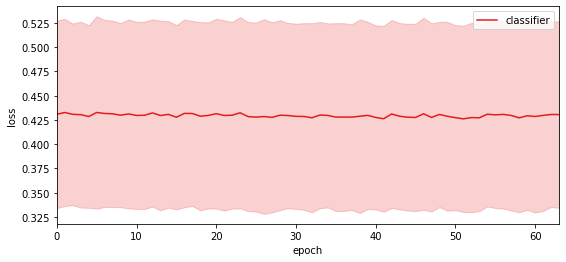

In [25]:
from mlhep2019.pivot import plot_losses
plot_losses(classifier=losses)

In [27]:
assert np.mean(losses[-1, :]) < np.log(2), 'Classifier seems to not learn anything'
assert np.mean(losses[-1, :]) > 0, 'Perhaps, you forgot to fill `losses_clf` array with actual loss values?'

## Let's pivot

In [41]:
class Adversary(torch.nn.Module):
    ### define adversary here
    ### don't forget about torch.squeeze
    def __init__(self, activation=torch.nn.LeakyReLU()):
        super(Adversary, self).__init__()
        
        self.Layer1 = torch.nn.Linear(1,64)
        self.Layer2 = torch.nn.Linear(64,1)
        
        self.activation = activation
        
    def forward(self, X):
        
        result = X
        result = self.activation(self.Layer1(result))
        
        return torch.squeeze(self.Layer2(result), dim=1)

In [42]:
pclf = Classifier().to(device)

### define pivoted classifier loss here
loss_fn_pclf = torch.functional.F.binary_cross_entropy

adv = Adversary().to(device)

### define adversary loss here
loss_fn_adv = torch.nn.MSELoss()

In [43]:
assert pclf(torch.randn(3, data_train.shape[1]).to(device)).to('cpu').detach().numpy().shape == (3, )

In [46]:
n_epoches = 64
n_batches = 1024

losses_clf = np.zeros((n_epoches, n_batches), dtype='float32')
losses_adv = np.zeros((n_epoches, n_batches), dtype='float32')

opt_pclf = torch.optim.Adam(pclf.parameters(), lr=1e-3)
opt_adv = torch.optim.Adamax(adv.parameters(), lr=5e-3)

for i in range(n_epoches):
    for j in range(n_batches):
        for k in range(16):
            indx = torch.randint(0, data_train.shape[0], size=(32, ))
            X_batch, y_batch, z_batch = X_train[indx], y_train[indx], z_train[indx]
            
            y_pred = pclf(X_batch)
            z_pred = adv(torch.unsqueeze(y_pred, dim=1))
            
            loss_adv = loss_fn_adv(z_pred,z_batch)
            
            loss_adv.backward()
            
            opt_adv.step()
            
            opt_adv.zero_grad()
            
            
        indx = torch.randint(0, data_train.shape[0], size=(32, ))
        X_batch, y_batch, z_batch = X_train[indx], y_train[indx], z_train[indx]
        
        y_pred = pclf(X_batch)
        z_pred = adv(torch.unsqueeze(y_pred, dim=1))
        
        loss_pclf = loss_fn_pclf(y_pred,y_batch) - 1 * loss_fn_adv(z_pred,z_batch)
        
        loss_pclf.backward()
        
        opt_pclf.step()
        
        opt_pclf.zero_grad()
        
        losses_clf[i, j] = loss_pclf.item()
        losses_adv[i, j] = loss_adv.item()

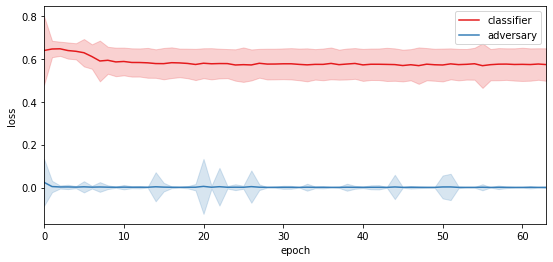

In [47]:
plot_losses(classifier=losses_clf, adversary=losses_adv)

In [48]:
assert np.mean(losses_clf[-1, :]) < np.log(2), 'The classifier seems to not learn anything.'
assert np.mean(losses_clf[-1, :]) > 0, 'Perhaps, you forgot to fill `losses_clf` array with actual loss values?'
assert np.mean(losses_adv[-1, :]) > 0, 'Perhaps, you forgot to fill `losses_adv` array with actual loss values?'

## Results

/work/threiten/conda-envs/py3-pytorch/lib/python3.7/site-packages/mlhep2019/pivot/utils.py:30: RuntimeWarning: divide by zero encountered in log
  np.where(hist > 0, pmf * (np.log(pmf) - np.log(marginal_x)[:, None]), 0)


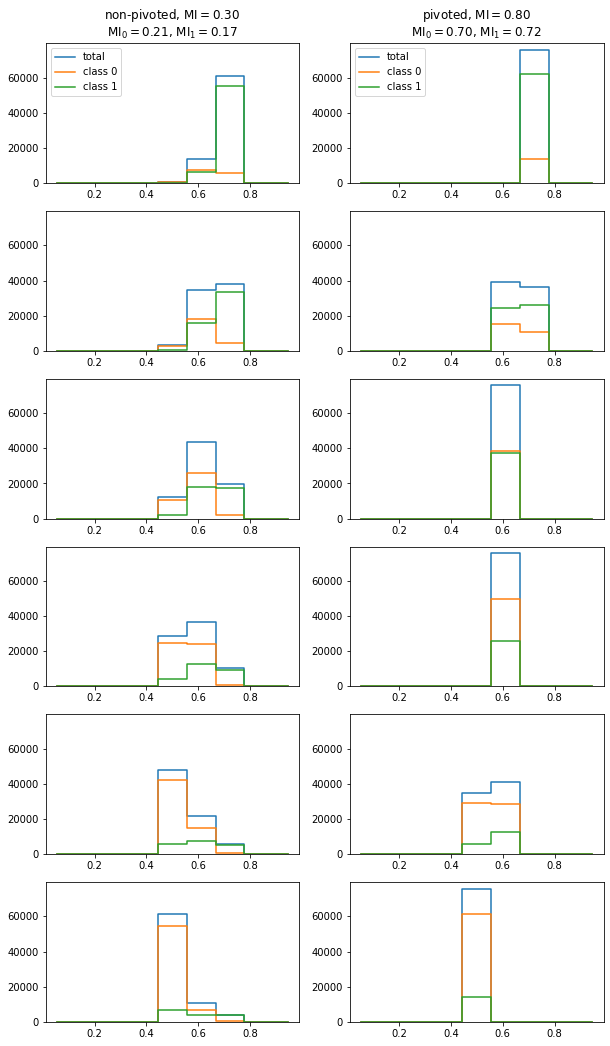

In [49]:
nuisance_prediction_hist([
        test_predictions(clf),
        test_predictions(pclf),
    ],
    nuisance_test, nuisance_bins=6,
    labels=labels_test.astype('int'),
    names=['non-pivoted', 'pivoted']
)

In [50]:
from sklearn.metrics import roc_auc_score

The following figure shows dependency between predictions and the nuisance parameter:
- each column correspond to a different model;
- rows correspond to nuisance parameter bins;
- each plot show distribution of model predictions within the corresponding nuisance bin.

- $\mathrm{MI}$ - (unconditional) mutual information between the nuisance parameter and model predictions.
- $\mathrm{MI}_i$ - mutual information between the nuisance parameter and model predictions **within** $i$-th class.

**Note**, that the following Mutual Information estimates migh be unreliable.

In [51]:
nuisance_metric_plot([
        test_predictions(clf),
        test_predictions(pclf),
    ],
    labels=labels_test,
    nuisance=nuisance_test.astype('int'),
    metric_fn=roc_auc_score, metric_name='ROC AUC',
    names=['non-pivoted', 'pivoted']
)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.